In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install scikit-image opencv-python torch torchvision scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [4]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from torchvision import models, transforms
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from PIL import Image


In [5]:
def extract_lbp_glcm_features(img_gray):
    # --- LBP ---
    lbp = local_binary_pattern(img_gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    # --- GLCM ---
    glcm = graycomatrix(img_gray, [1], [0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    glcm_features = [contrast, correlation, energy, homogeneity]
    return np.concatenate([hist, glcm_features])


In [6]:
cnn_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
cnn_model.fc = nn.Identity()
cnn_model.eval()

cnn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def extract_cnn_features(img_rgb):
    img_tensor = cnn_transform(Image.fromarray(img_rgb)).unsqueeze(0)
    with torch.no_grad():
        features = cnn_model(img_tensor)
    return features.squeeze().numpy()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s] 


In [7]:
dataset_path = '/kaggle/input/blood-cell-images-for-cancer-detection'  # adjust path
X = []
y = []
labels = os.listdir(dataset_path)

for label in labels:
    img_dir = os.path.join(dataset_path, label)
    for file in os.listdir(img_dir):
        path = os.path.join(img_dir, file)
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        lbp_glcm_feat = extract_lbp_glcm_features(img_gray)
        cnn_feat = extract_cnn_features(img_rgb)
        combined_feat = np.hstack((lbp_glcm_feat, cnn_feat))

        X.append(combined_feat)
        y.append(label)


In [38]:
# check the directory for combined features
import os
os.listdir('/kaggle/working/')

['features_combine.npy',
 'mlp_classifier.pth',
 'labels.npy',
 'features_labels.pkl',
 '.virtual_documents']

In [18]:
import pickle

# Save
with open('features_labels.pkl', 'wb') as f:
    pickle.dump({'features': X, 'label': y}, f)

In [21]:
with open('features_labels.pkl', 'rb') as f:
    data = pickle.load(f)
    X = data['features']
    y = data['label']

In [22]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


                precision    recall  f1-score   support

      basophil       0.95      0.93      0.94       190
  erythroblast       0.97      0.95      0.96       192
      monocyte       0.94      0.98      0.96       216
    myeloblast       0.98      0.98      0.98       192
seg_neutrophil       0.98      0.98      0.98       210

      accuracy                           0.96      1000
     macro avg       0.96      0.96      0.96      1000
  weighted avg       0.96      0.96      0.96      1000



In [33]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Assume X = features (CNN+LBP+GLCM), y = original labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split and convert to tensors
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Define MLP
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPClassifier(input_size=X.shape[1], num_classes=len(np.unique(y_encoded))).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

# Training loop
for epoch in range(15):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(preds, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            predicted = torch.argmax(preds, 1)
            correct_val += (predicted == yb).sum().item()
            total_val += yb.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Acc = {val_accuracy:.4f}")



Epoch 1: Train Loss = 0.7121, Val Loss = 0.2586, Train Acc = 0.7465, Val Acc = 0.9260
Epoch 2: Train Loss = 0.2756, Val Loss = 0.1556, Train Acc = 0.9045, Val Acc = 0.9480
Epoch 3: Train Loss = 0.1889, Val Loss = 0.1303, Train Acc = 0.9357, Val Acc = 0.9540
Epoch 4: Train Loss = 0.1542, Val Loss = 0.1039, Train Acc = 0.9470, Val Acc = 0.9620
Epoch 5: Train Loss = 0.1287, Val Loss = 0.0809, Train Acc = 0.9563, Val Acc = 0.9700
Epoch 6: Train Loss = 0.1121, Val Loss = 0.0798, Train Acc = 0.9595, Val Acc = 0.9760
Epoch 7: Train Loss = 0.1244, Val Loss = 0.0993, Train Acc = 0.9550, Val Acc = 0.9660
Epoch 8: Train Loss = 0.1113, Val Loss = 0.1051, Train Acc = 0.9615, Val Acc = 0.9640
Epoch 9: Train Loss = 0.0843, Val Loss = 0.0820, Train Acc = 0.9722, Val Acc = 0.9690
Epoch 10: Train Loss = 0.0892, Val Loss = 0.0858, Train Acc = 0.9700, Val Acc = 0.9670
Epoch 11: Train Loss = 0.0828, Val Loss = 0.0914, Train Acc = 0.9715, Val Acc = 0.9660
Epoch 12: Train Loss = 0.0703, Val Loss = 0.0655, Tr

In [31]:
# save the training model
#torch.save(model.state_dict(), '/kaggle/working/mlp_classifier.pth')

In [32]:
# Recreate the same model architecture

#model = MLPClassifier(input_size=X.shape[1], num_classes=len(np.unique(y_encoded))).to(device)

# Load the saved weights
#model.load_state_dict(torch.load('/kaggle/working/mlp_classifier.pth'))



Classification Report:
                precision    recall  f1-score   support

      basophil       0.97      0.96      0.97       190
  erythroblast       0.98      0.97      0.98       192
      monocyte       0.97      0.99      0.98       216
    myeloblast       0.99      0.99      0.99       192
seg_neutrophil       0.99      0.99      0.99       210

      accuracy                           0.98      1000
     macro avg       0.98      0.98      0.98      1000
  weighted avg       0.98      0.98      0.98      1000



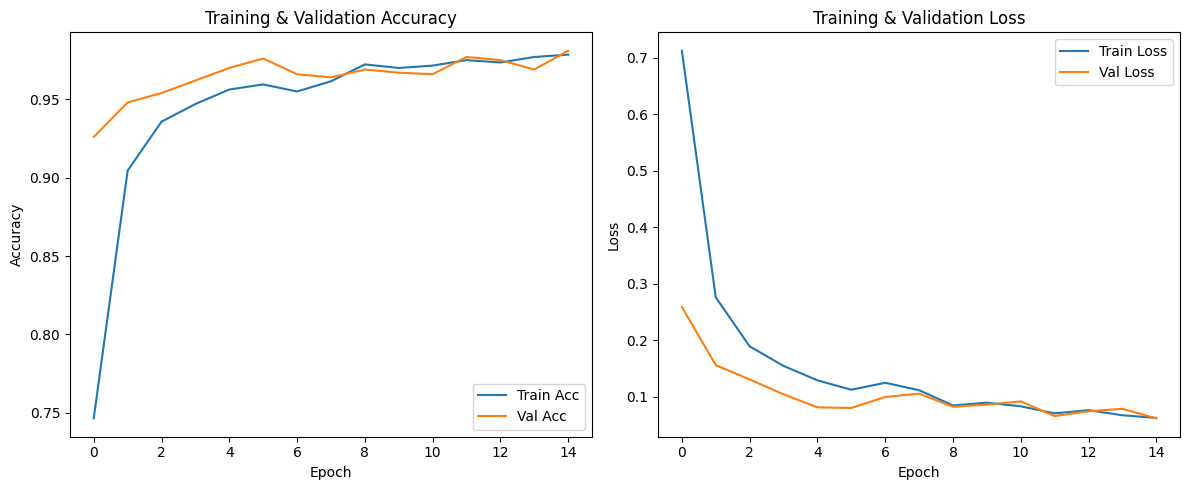

In [34]:
# Final Evaluation
model.eval()
all_preds = []
with torch.no_grad():
    for xb in X_test_tensor.to(device).split(64):
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_test, all_preds, target_names=le.classes_))

# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_list, label='Train Acc')
plt.plot(val_accuracy_list, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

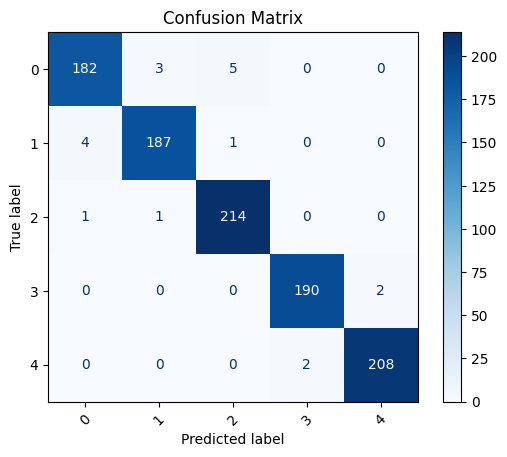

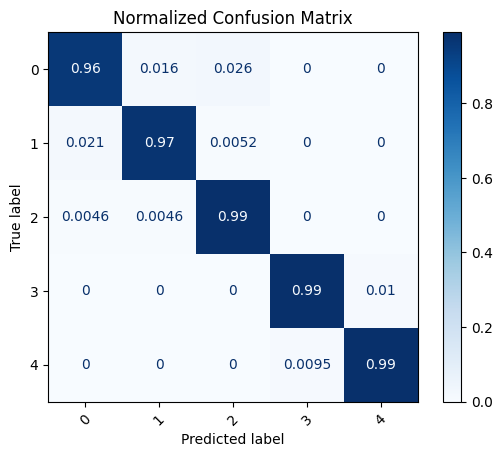

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Normalized Confusion Matrix")
plt.show()


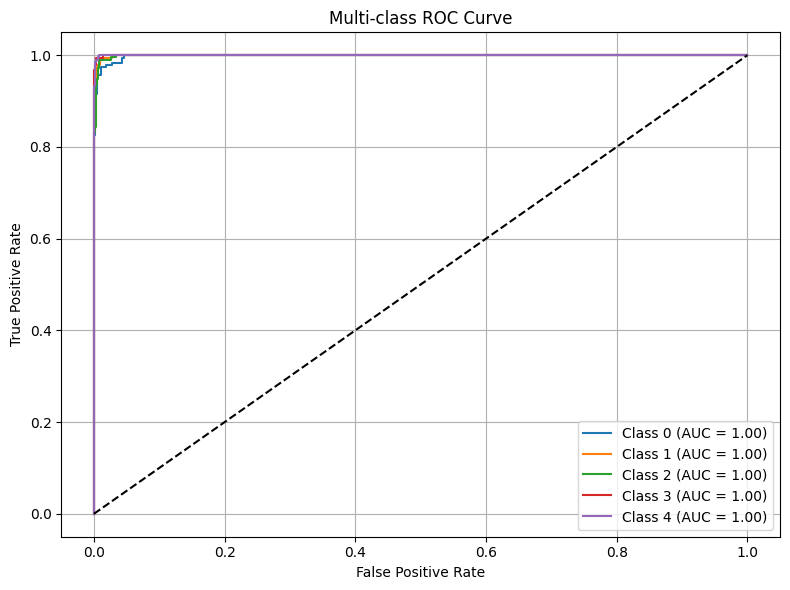

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# One-hot encode labels
n_classes = len(np.unique(y_encoded))
y_test_binarized = label_binarize(all_labels, classes=np.arange(n_classes))

# Get prediction probabilities
all_probs = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)

all_probs = np.array(all_probs)

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
